## T1.1 - Discrete-time solution of Hamilton's equations: the simple harmonic oscillator

In this lecture, I introduced several simple discrete-time integration algortithms for Hamilton's equations of motion, including the Euler, symplectic Euler, and velocity Verlet (or leapfrog) methods. In this tutorial, you will test these methods for solving the equations of motion for a system with a known exact solution, the 1D simple harmonic oscillator (SHO).

The instantaneous state of the 1D SHO at time $t$ corresponds to a point in the 2D *phase space* ($x(t)$,$p(t)$), where $x$ is the displacement and $p = m \dot{x}$ is the conjugate momentum. In terms of $x$ and $p$, the Hamiltonian of the 1D SHO is:

$$H(p,x) = \frac{p^2}{2m} + \frac{k x^2}{2},$$

where $m$ is the mass and $k$ is the spring constant. This leads to Hamilton's equations of motion,

$$\dot{x} = \frac{\partial H}{\partial p} = \frac{p}{m}$$

$$\dot{p} = - \frac{\partial H}{\partial x} = - k x.$$

These two first-order ODEs can be combined to obtain a single second-order ODE, $m \ddot{x} = - k x$,
which has the general solution

$$x(t) = A \sin(\omega t + \delta)$$

$$p(t) = A m \omega \cos(\omega t + \delta),$$

where $\omega = \sqrt{k/m}$ is the angular frequency of the oscillator. The period of oscillation is $T = 2 \pi / \omega = 2 \pi \sqrt{m/k}$.

It's instructive and convenient to formulate this problem (simple as it is) in dimensionless variables. It's natural to take $m$ to be the unit of mass, and $t_0 = \sqrt{m/k}$ to be the unit of time. To proceed further, we note that the energy of the system, $E = H(p,x)$, is a constant of the motion, which can be taken to be the unit of energy, so the unit of length is $x_0 = \sqrt{E/k}$ and the unit of momentum is $p_0 = \sqrt{E m}$.

We now define the dimensionless position $X = x / x_0 = x / \sqrt{E / k}$ and the dimensionless momentum $P = p / p_0 = p / \sqrt{E m}$. Making this variable substitution in the Hamiltonian then gives

$${\cal H}(P,X) = \frac{1}{2} P^2 + \frac{1}{2} X^2,$$

where we have defined the dimensionless Hamiltonian ${\cal H}(P,X) = H(P,X) / E = 1$. It can be verified that $P$ and $X$ are still canonically conjugate variables in this new formulation.

Hamilton's equations of motion now become

$$\dot{X} = \frac{\partial \cal{H}}{\partial P} = P$$

$$\dot{P} = - \frac{\partial \cal{H}}{\partial X} = - X,$$

where the dots now indicate differentiation with respect to the dimensionless time variable $\tau = t / t_0$. These equations have solution

$$X(\tau) = \sqrt{2} \sin(\tau + \delta)$$

$$P(\tau) = \sqrt{2} \cos(\tau + \delta).$$

Note that the constant of integration is determined from the constraint ${\cal H}(P,X) = 1$. As a function of $\tau$, the system traces out a circular path of radius $\sqrt{2}$ in the $(X,P)$ phase space, with angular frequency $1$ and period $2 \pi$. This is as simple as it gets: the only remaining free parameter in the model is the phase angle $\delta$, which determines the initial condition at $\tau = 0$.

The purpose of this rather tedious exercise is not only to facilitate the subsequent analysis, but to illustrate the importance of introducing an appropriate, minimal set of dimensionless parameters prior to theoretical study or numerical simulation of any physical system. There's no need to investigate how the behavior of the SHO varies with $m$ or $k$ or $E$, as all SHOs map into the unique dimensionless model described above.

In [1]:
using Revise;
using Plots;
using LaTeXStrings;
# Set a common end time
t_end = 10*π;
dt = 0.01;
Nt = Int(ceil(t_end/dt));

In [2]:
# Analytic answer for the simple harmonic oscillator
Xanalytic = zeros(Nt);
Panalytic = zeros(Nt);
function AnalyticSHO!(X::Vector{Float64}, P::Vector{Float64}, Nt::Int, dt::Float64, phi)
    for i = 1:Nt
        X[i] = sqrt(2) * sin((i-1)*dt + phi)
        P[i] = sqrt(2) * cos((i-1)*dt + phi)
    end
    nothing
end
AnalyticSHO!(Xanalytic, Panalytic, Nt, dt, π/2);

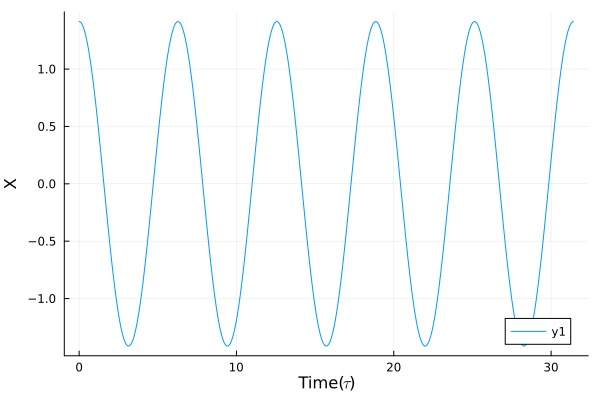

In [3]:
# How does the position change over time?
plot(range(0.0, t_end, Nt), Xanalytic, xlabel = L"""Time($\tau$)""", ylabel = "X")

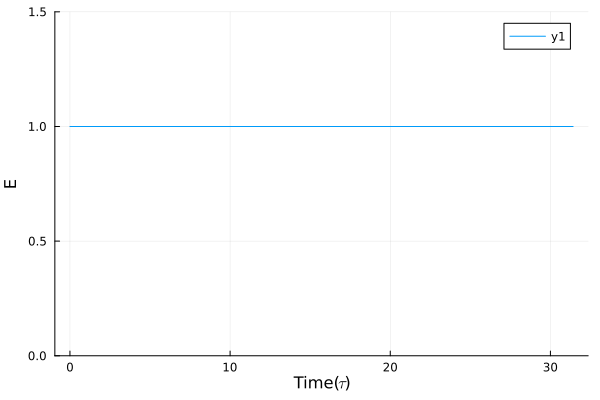

In [4]:
# How does the energy look?
plot(range(0.0, t_end, Nt), (0.5*Xanalytic.^2+0.5*Panalytic.^2), xlabel = L"""Time($\tau$)""", ylabel = "E", ylims=(0.0, 1.5))

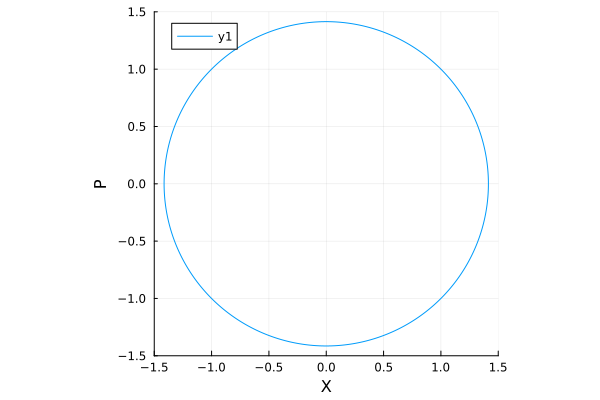

In [5]:
# The analytic answer should be perfect
plot(Xanalytic, Panalytic, xlims=(-1.5,1.5), ylims=(-1.5,1.5), aspect_ratio=1, xlabel = "X", ylabel = "P")

## T1.2 - The forward Euler algorithm

Now consider discrete-time solutions of Hamilton's equations for the SHO:

$$\frac{d X}{d t} = P$$

$$\frac{d P}{d t} = -X$$

(note that I'm now using $t$ instead of $\tau$ to denote the dimensionless time variable). Writing discrete-time approximations for the derivatives,

$$\frac{d X}{d t} \approx \frac{\Delta X}{\Delta t} = \frac{X(t + \Delta t) - X(t)}{\Delta t} = P(t)$$

$$\frac{d P}{d t} \approx \frac{\Delta P}{\Delta t} = \frac{P(t + \Delta t) - P(t)}{\Delta t} = - X(t),$$

leads immediately to the Euler algorithm,

$$X(t + \Delta t) = X(t) + P(t) \Delta t$$

$$P(t + \Delta t) = P(t) - X(t) \Delta t.$$

Note that both the position and momentum are updated simultaneously in the Euler scheme.

We can now write a Julia program to integrate the equations of motion of the SHO over several periods of oscillation using the Euler integrator, and plot the phase-space trajectory of the system as a function of $t$ in the $(X,P)$ plane. Also plot the total energy $E = {\cal H}(P,X)$ as a function of $t$. Compare these results with the exact solution, and explore the behavior as a function of the timestep $\Delta t$. Do you recover the exact dynamics for sufficiently small $\Delta t$?

In [6]:
# Forward Euler for the Simple Harmonic Oscillator
XforwardEuler = zeros(Nt);
PforwardEuler = zeros(Nt);
function ForwardEulerSHO!(X::Vector{Float64}, P::Vector{Float64}, Nt::Int, dt::Float64, phi)
    X[1] = sqrt(2) * sin(phi);
    P[1] = sqrt(2) * cos(phi);
    for i = 1:Nt-1
        X[i+1] = X[i] + P[i] * dt;
        P[i+1] = P[i] - X[i] * dt;
    end
    nothing
end
ForwardEulerSHO!(XforwardEuler, PforwardEuler, Nt, dt, π/2);

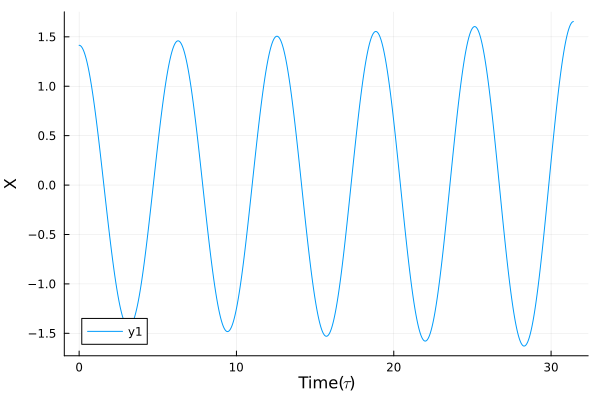

In [7]:
# How does the position change over time?
plot(range(0.0, t_end, Nt), XforwardEuler, xlabel = L"""Time($\tau$)""", ylabel = "X")

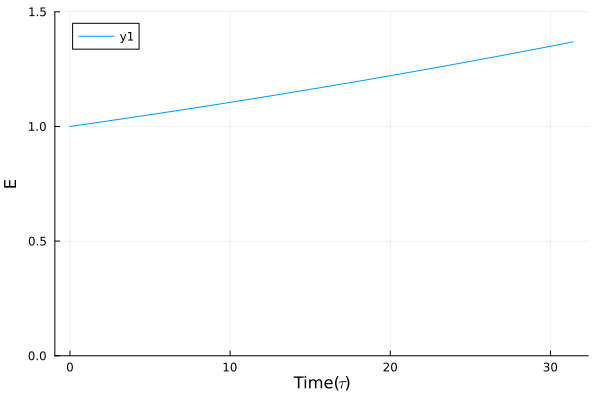

In [8]:
# How does the energy look?|
plot(range(0.0, t_end, Nt), (0.5*XforwardEuler.^2+0.5*PforwardEuler.^2), xlabel = L"""Time($\tau$)""", ylabel = "E", ylims=(0.0, 1.5))

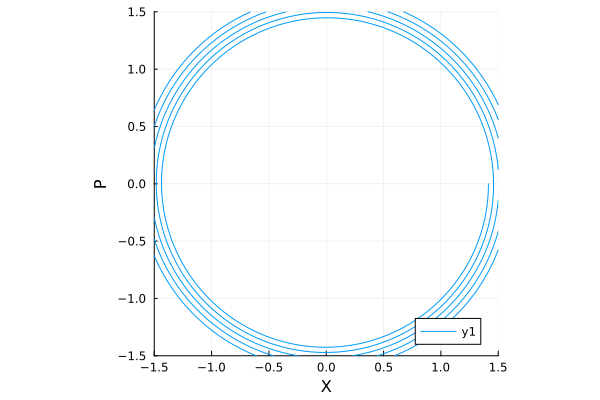

In [9]:
# Are we conserving the phase space volume?
plot(XforwardEuler, PforwardEuler, xlims=(-1.5,1.5), ylims=(-1.5,1.5), aspect_ratio=1, xlabel = "X", ylabel = "P")

## T1.3 - The symplectic Euler algorithm

Now investigate the discrete-time integration of the equations of motion for the 1D SHO using the symplectic Euler algorithm,

$$X(t + \Delta t) = X(t) + P(t) \Delta t$$

$$P(t + \Delta t) = P(t) - X(t + \Delta t) \Delta t.$$

Note that, unlike the Euler algorithm, this method involves a specific sequence of operations: first, the position is updated using the momentum at time $t$, then the momentum is updated using the new position (and the corresponding force $-X$) at time $t + \Delta t$.

Write a Julia program to integrate the equations of motion of the SHO over several periods of oscillation using the symplectic Euler integrator, and plot the phase-space trajectory and total energy of the system as a function of $t$. Compare these results with the exact solution, and explore the behavior as a function of the timestep $\Delta t$. How does the dynamics differ from that of the exact solution? Does the discrete-time dynamics display a well-defined period, and if so, is it equal to $2 \pi$?

In [10]:
# Symplectic Euler for the Simple Harmonic Oscillator
XsymplecticEuler = zeros(Nt);
PsymplecticEuler = zeros(Nt);
function SymplecticEulerSHO!(X::Vector{Float64}, P::Vector{Float64}, Nt::Int, dt::Float64, phi)
    X[1] = sqrt(2) * sin(phi);
    P[1] = sqrt(2) * cos(phi);
    for i = 1:Nt-1
        X[i+1] = X[i] + P[i] * dt;
        P[i+1] = P[i] - X[i+1] * dt;
    end
    nothing
end
SymplecticEulerSHO!(XsymplecticEuler, PsymplecticEuler, Nt, dt, π/2);

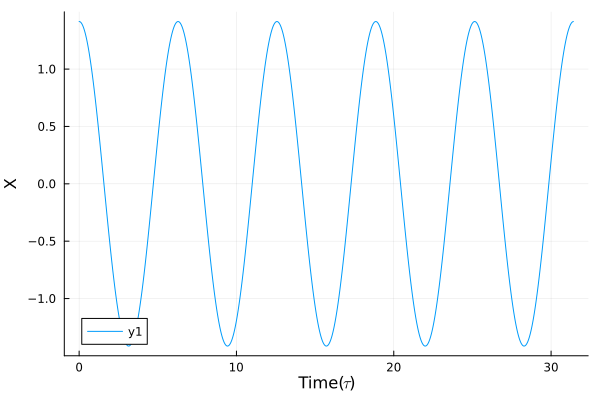

In [11]:
# How does the position change over time?
plot(range(0.0, t_end, Nt), XsymplecticEuler, xlabel = L"""Time($\tau$)""", ylabel = "X")

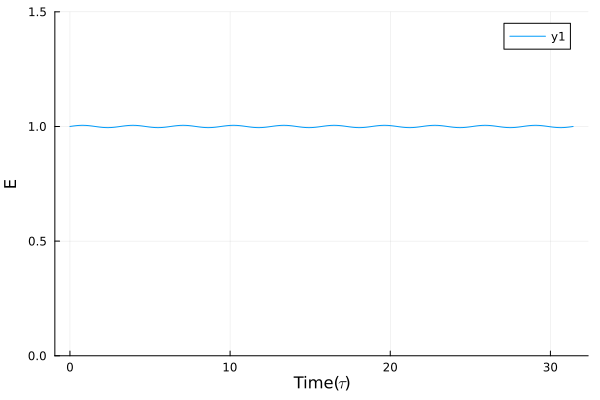

In [12]:
# How does the energy look?
plot(range(0.0, t_end, Nt), (0.5*XsymplecticEuler.^2+0.5*PsymplecticEuler.^2), xlabel = L"""Time($\tau$)""", ylabel = "E", ylims=(0.0, 1.5))

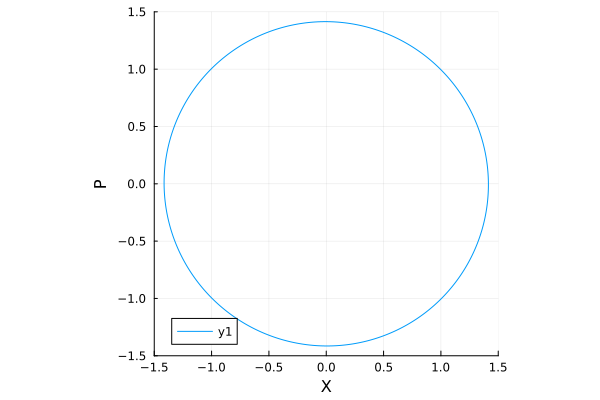

In [13]:
# Are we conserving the phase space volume?
plot(XsymplecticEuler, PsymplecticEuler, xlims=(-1.5,1.5), ylims=(-1.5,1.5), aspect_ratio=1, xlabel = "X", ylabel = "P")

## T1.4 - The velocity Verlet algorithm

Finally, investigate the discrete-time integration of the equations of motion for the 1D SHO using the velocity Verlet (or leapfrog) algorithm,

$$P \left(t + \frac{\Delta t}{2} \right) = P(t) - X(t) \frac{\Delta t}{2}$$

$$X(t + \Delta t) = X(t) + P \left(t + \frac{\Delta t}{2} \right) \Delta t$$

$$P(t + \Delta t) = P \left(t + \frac{\Delta t}{2} \right) - X(t + \Delta t) \frac{\Delta t}{2}.$$

As for the symplectic Euler algorithm, a specific sequence of operations is implied here: first a half-timestep update of momentum using the initial force $- X(t)$, then a full-timestep update of the position using the midstep momentum $P(t + \Delta t/2)$, and finally a half-timestep update of the momentum using the final force $- X(t + \Delta t)$.

Write a Julia program to integrate the equations of motion of the SHO over several periods of oscillation using the velocity Verlet integrator, and plot the phase-space trajectory and total energy of the system as a function of $t$. Compare these results with the exact solution, and explore the behavior as a function of the timestep $\Delta t$. Is the velocity Verlet method stable? Is the energy well-conserved over large time intervals? What happens if you make the timestep large compared with the period of the SHO?

The symmetric structure of the velocity Verlet algorithm implies that it is time-reversible. Verify this directly by integrating the SHO forward in time over some finite (large) time interval, then reversing the momentum and integrating forward in time over the same time interval. You should arrive back at the same phase space point, to a high degree of precision. In the same way, show that the symplectic Euler algorithm is *not* time reversible (even though it is rather stable).

In [14]:
# Velocity-Verlet for the Simple Harmonic Oscillator
XvelocityVerlet = zeros(Nt);
PvelocityVerlet = zeros(Nt);
function VelocityVerletSHO!(X::Vector{Float64}, P::Vector{Float64}, Nt::Int, dt::Float64, phi)
    X[1] = sqrt(2) * sin(phi);
    P[1] = sqrt(2) * cos(phi);
    for i = 1:Nt-1
        Phalf = P[i] - X[i]*dt/2.0;
        X[i+1] = X[i] + Phalf*dt;
        P[i+1] = Phalf - X[i+1]*dt/2.0;
    end
    nothing
end
VelocityVerletSHO!(XvelocityVerlet, PvelocityVerlet, Nt, dt, π/2);

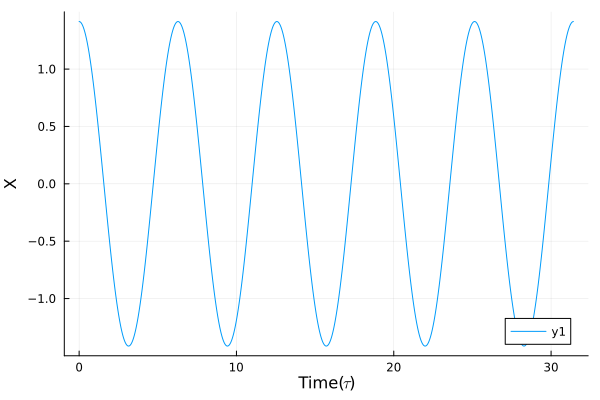

In [15]:
# How does the position change over time?
plot(range(0.0, t_end, Nt), XvelocityVerlet, xlabel = L"""Time($\tau$)""", ylabel = "X")

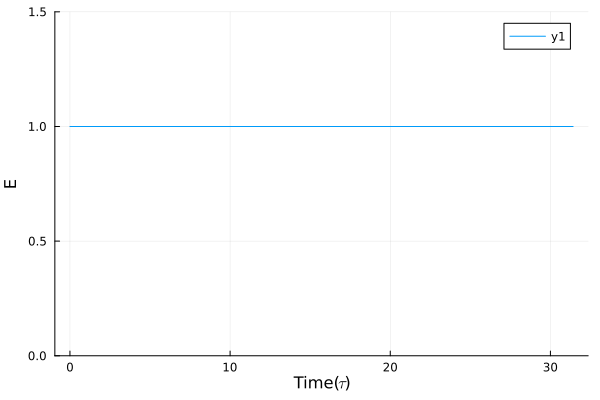

In [16]:
# How does the energy look?
plot(range(0.0, t_end, Nt), (0.5*XvelocityVerlet.^2+0.5*PvelocityVerlet.^2), xlabel = L"""Time($\tau$)""", ylabel = "E", ylims=(0.0, 1.5))

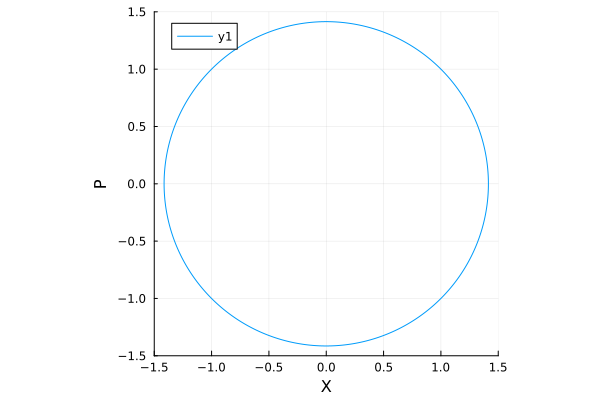

In [17]:
# Are we conserving the phase space volume?
plot(XvelocityVerlet, PvelocityVerlet, xlims=(-1.5,1.5), ylims=(-1.5,1.5), aspect_ratio=1, xlabel = "X", ylabel = "P")